In [1]:
import numpy as np
import pandas as pd

In [2]:
import unittest

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
sns.set(rc={'figure.figsize':(13,5)})

1. A->constant UA = B-> constant UA
2. A->changing(version) UA <= B-> changing(version)UA
3. A and B were in the same IP/routers (we currently still work with ips so we need to make sure the ip didnt jump and we are actually looking at two different routers. this is important because we can see two cookies that are actually in different routers and not actually connected at all but think that they are)
4. A stopped appearing in any ip before B started appearing for the first time

In [5]:
def versions_key(versions_series):
    expanded = versions_series.str.split('.', expand=True).fillna(value='0').astype(int)
    return (expanded.iloc[:,::-1] * [10**i for i in range(0, len(expanded.columns))]).sum(axis=1)

In [6]:
def trim_version(version):
    parts = version.split('.')
    last_nonzero_part = len(parts)
    found_non_zero = False
    for i in range(len(parts)-1, -1, -1):
        if int(parts[i]) != 0:
            last_nonzero_part = i+1
            found_non_zero = True
            break
    trimmed_parts = parts[:last_nonzero_part]
    return trimmed_parts if found_non_zero else ['0']


def compare_versions(version1, version2):    
    # split and remove trailing zeros, as we treat them as 'unkown'
    v1 = trim_version(version1)
    v2 = trim_version(version2)
    
    len1, len2 = len(v1), len(v2)
    i = 0
    
    while i < len1 or i < len2:
        if i >= len1 or i >= len2:
            return 0 # if one is a prefix of the other then for our purposes they are equal
        
        if int(v1[i]) < int(v2[i]):
            return -1  # version 1 is less than version 2
        elif int(v1[i]) > int(v2[i]):
            return 1   # version 1 is greater than version 2
        
        i += 1
    
    return 0  # version 1 is equal to version 2

In [7]:
class TestVersionFunctions(unittest.TestCase):
    
    def test_trim_version(self):
        self.assertEqual(trim_version('1.0.0'), ['1'])
        self.assertEqual(trim_version('1.2.3.0'), ['1','2','3'])
        self.assertEqual(trim_version('0'), ['0'])
        self.assertEqual(trim_version('0.0.0.0'), ['0'])
        self.assertEqual(trim_version('10.0'), ['10'])
        self.assertEqual(trim_version('1.2.3.4.5.6.7.8.9'), ['1','2','3','4','5','6','7','8','9'])
        
    def test_compare_versions(self):
        self.assertEqual(compare_versions('1', '2'), -1)
        self.assertEqual(compare_versions('1.0.0', '1.0'), 0)
        self.assertEqual(compare_versions('1.2.3', '1.2.3.0'), 0)
        self.assertEqual(compare_versions('1.2.3', '1.2.2'), 1)
        self.assertEqual(compare_versions('2.3.4', '1.3.4'), 1)
        self.assertEqual(compare_versions('1.2.3', '1.2.4'), -1)
        self.assertEqual(compare_versions('1.2.3', '1.2.3.4'), 0)
        self.assertEqual(compare_versions('1.2.3.4', '1.2.3'), 0)
        self.assertEqual(compare_versions('1.2.3.4', '1.2.3.4'), 0)
        self.assertEqual(compare_versions('0', '0.0'), 0)
        self.assertEqual(compare_versions('108.0.0.0', '108.1.5.3'), 0)
        self.assertEqual(compare_versions('108.3', '108.2.3.1'), 1)


In [8]:
unittest.main(argv=[''], verbosity=2, exit=False)

test_compare_versions (__main__.TestVersionFunctions) ... ok
test_trim_version (__main__.TestVersionFunctions) ... ok

----------------------------------------------------------------------
Ran 2 tests in 0.001s

OK


In [9]:
# class TestCompareVersions(unittest.TestCase):
#     def test_equal_versions(self):
#         self.assertEqual(compare_versions('1.2.3', '1.2.3'), 0)
#         self.assertEqual(compare_versions('0.0.0', '0.0.0'), 0)
#         self.assertEqual(compare_versions('10.20.30', '10.20.30'), 0)
        
#     def test_lesser_versions(self):
#         self.assertEqual(compare_versions('1.2.3', '1.2.4'), -1)
#         self.assertEqual(compare_versions('1.2.3', '1.3.0'), -1)
#         self.assertEqual(compare_versions('1.2.3', '2.0.0'), -1)
#         self.assertEqual(compare_versions('1.2.3', '1.2.4.5'), -1)
        
#     def test_greater_versions(self):
#         self.assertEqual(compare_versions('1.2.4', '1.2.3'), 1)
#         self.assertEqual(compare_versions('1.3.0', '1.2.3'), 1)
#         self.assertEqual(compare_versions('2.0.0', '1.2.3'), 1)
#         self.assertEqual(compare_versions('1.2.4.5', '1.2.3'), 1)
        
#     def test_prefix_versions(self):
#         self.assertEqual(compare_versions('1.2', '1.2.0'), 0)
#         self.assertEqual(compare_versions('1.2.0', '1.2'), 0)
#         self.assertEqual(compare_versions('1.2', '1.2.3'), -1)
#         self.assertEqual(compare_versions('1.2.3', '1.2'), 1)


In [10]:
# unittest.main(argv=[''], verbosity=2, exit=False)

In [11]:
def constUA(row):
    return row[['brand','model', 'os', 'browser', 'advertisedbrowser']]

def constUAconsistent(row1, row2):
    return constUA(row1).equals(constUA(row2))

def changinUAconsistent(row1, row2):
    os_consistent = compare_versions(row1['osversion'], row2['osversion']) <= 0
    browser_consistent = compare_versions(row1['browserversion'], row2['browserversion']) <= 0
    return os_consistent and browser_consistent
                          
def time_intersection(row1, row2):
    row1['timestamp'] < row2['timestamp']

In [12]:
def candidate_cookies(df, cookie1, cookie2):
    df_cookie1 = df[df['iiqid'] == cookie1]
    df_cookie2 = df[df['iiqid'] == cookie2]
    first_ck1, last_ck1 = df_cookie1.iloc[df_cookie1['timestamp'].argmin()], df_cookie1.iloc[df_cookie1['timestamp'].argmax()]
    first_ck2, last_ck2 = df_cookie2.iloc[df_cookie2['timestamp'].argmin()], df_cookie2.iloc[df_cookie2['timestamp'].argmax()]
    if last_ck1['timestamp'] < first_ck2['timestamp']:
        # print(f"constUAconsistent: {constUAconsistent(last_ck1, first_ck2)}")   
        # print(f"changinUAconsistent: {changinUAconsistent(last_ck1, first_ck2)}")
        return constUAconsistent(last_ck1, first_ck2) and   changinUAconsistent(last_ck1, first_ck2)
    elif first_ck1['timestamp'] > last_ck2['timestamp']:
        # print(f"constUAconsistent: {constUAconsistent(first_ck1, last_ck2)}")
        # print(f"changinUAconsistent: {changinUAconsistent(first_ck1, last_ck2)}")
        return constUAconsistent(first_ck1, last_ck2) and   changinUAconsistent(first_ck1, last_ck2)
        
    return False

## Find Simple Cases

In [13]:
data = pd.read_csv("houses1000.csv")

In [14]:
needed_columns = ['timestamp', 'maid', 'hh_id','iiqid', 'partner_id', 'ip', 'iscellip',
       'cellispid', 'domain','is_house_ip_or_source_ip', 'brand', 'model', 'os', 'osversion',
       'browser', 'advertisedbrowser', 'browserversion', 'type', 'is_best_ip']
unnecessary_columns = [c for c in data.columns if c not in needed_columns]

In [15]:
data.drop(unnecessary_columns, axis=1, inplace=True)

In [16]:
third_parties = data[(data['maid'] == 4) | (data['maid'] == 7)]

In [17]:
third_parties['hh_id'].nunique()

990

In [18]:
third_parties['time'] = pd.to_datetime(third_parties['timestamp'], unit='ms')

/var/folders/nw/8w_76z_n6fz418hmsps2_rq40000gn/T/ipykernel_76847/4172549046.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  third_parties['time'] = pd.to_datetime(third_parties['timestamp'], unit='ms')


In [19]:
third_parties = third_parties.dropna()

### Find Those Examples

In [26]:
import itertools

found = False
while not found:
    random_hh_id = np.random.choice(third_parties['hh_id'])
    random_h = third_parties[third_parties['hh_id']==random_hh_id]
    if random_h['iiqid'].nunique() > 1:
        for cookie_tuple in itertools.combinations(random_h['iiqid'].unique(), r=3):
            # print(pair)
            test_first_pair = candidate_cookies(random_h, cookie_tuple[0], cookie_tuple[1])
            test_second_pair = candidate_cookies(random_h, cookie_tuple[1], cookie_tuple[2])
            if test_first_pair and test_second_pair:
                print("Found!")
                found = True
                break

Found!


In [27]:
cookie_tuple

('GHiQzFIyYs', 'tTv4LCVoih', 'lgfTzVaAVP')

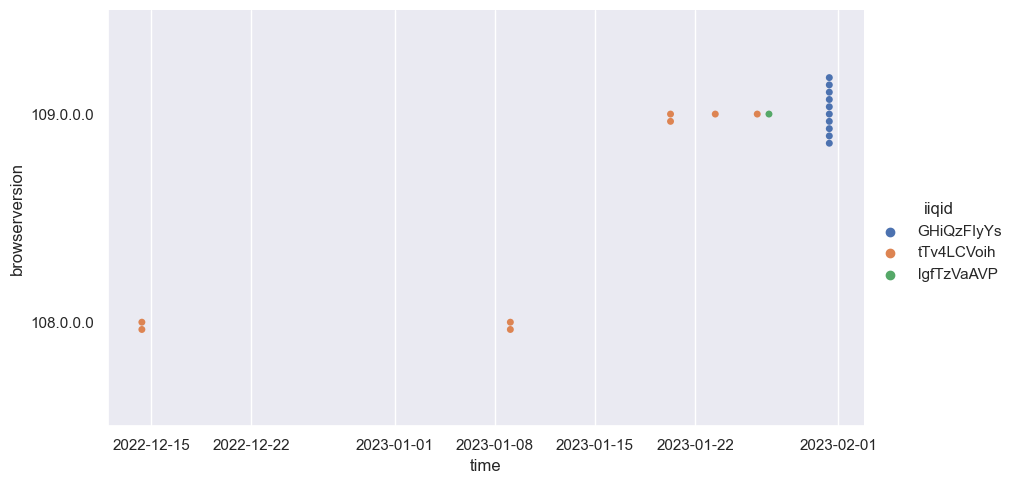

In [28]:
sns.catplot(data=random_h[random_h['iiqid'].isin (cookie_tuple)], x='time', y='browserversion', 
            hue='iiqid', kind='swarm', legend_out=True, height=5, aspect=1.8)

In [29]:
# from functools import cmp_to_key

In [30]:
cookie_data = random_h[random_h['iiqid'].isin(cookie_tuple)]
sorted_cookies = cookie_data.sort_values(by='browserversion', key=versions_key, ascending=False)

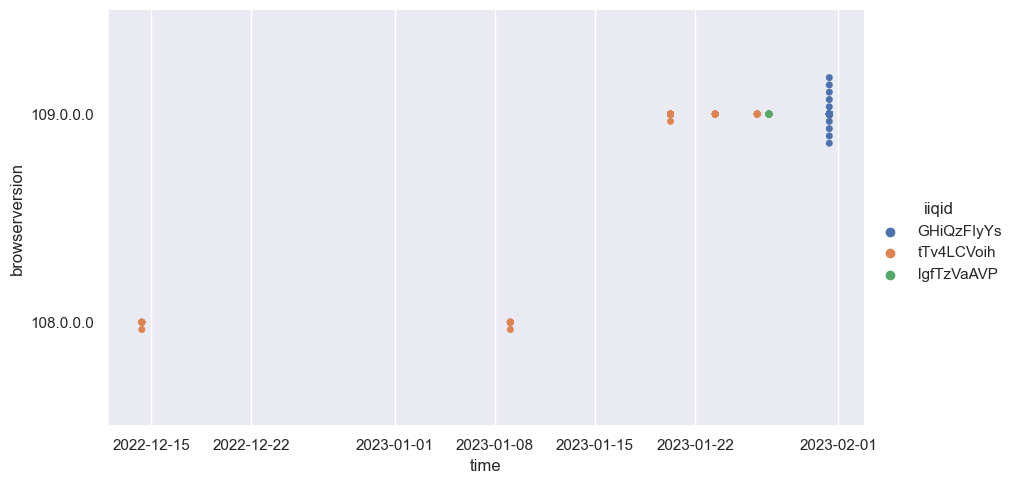

In [31]:
sns.catplot(data=cookie_data, x='time', y='browserversion', 
            hue='iiqid', kind='swarm', order=sorted_cookies.browserversion, legend_out=True, height=5, aspect=1.8)